# Preparation

This project aims on using Deep Learning with Kullback-Leibler Divergence. Some basic packages are required for this project. The aim of the following chunk is to install required packages such as `lifelines`, `sklearn-pandas` and `torchtuples`. Note that `pycox` is built based on `torchtuples`.

---

`pycox` should be pre-installed and removed into the google drive since we need to modify part of the code in this package for our model. However in the tutorial, we can actually predefine our loss function outside the package, so this part need to be updated probably.


In [1]:
!pwd
!pip install lifelines
! pip install sklearn-pandas
! pip install torchtuples
# ! pip install statsmodels
! pip install statsmodels --upgrade
# ! pip install pycox

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 349 kB 11.8 MB/s 
     |████████████████████████████████| 68 kB 4.3 MB/s 
     |████████████████████████████████| 38.1 MB 6.6 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=1a6248ecd06fafd9f2c42b3c7d4f7e7e2e6c8e0e749d20a35af27ac812179b20
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is inc

`pycox` is pre-installed in /content/drive/MyDrive/pycox, before that we need to track the data in google drive.

In [2]:
from google.colab import drive

drive.mount("/content/drive")

%cd "/content/drive/MyDrive/pycox"
# %pwd
# from pycox.models import LogisticHazard

Mounted at /content/drive
/content/drive/MyDrive/pycox


In [3]:
import os
import sys

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch # For building the networks 
import torchtuples as tt # Some useful functions

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [4]:
np.random.seed(1234)
_ = torch.manual_seed(1234)

If you have mounted the data rightly, you should print out the list for files in given folder. For example, this will print out all files in `/content/drive/My Drive/Kevin He`

In [5]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2022WI folder and put all the files under A4 folder, then "2022WI/A4"
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "Kevin He"
GOOGLE_DRIVE_PATH = os.path.join("/content/drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['Deep Learning with KL Divergence Simulation 1: Tutorial', 'local_data.csv', 'prior_data.csv', 'local_data_2.csv', 'local_data_3.csv', 'prior_data_subset.csv', 'prior_data_subset_2.csv', 'prior_data_subset_3.csv', 'R-code.ipynb', 'local_data_together.csv', 'Untitled', 'Deep Learning with KL Divergence Simulation Image Data.ipynb', 'Deep Learning with KL Divergence.ipynb', 'Deep Learning with KL Divergence Real Data.ipynb', 'prior_data_subset_4.csv', 'Deep Learning with KL Divergence Simulation Non-linear-prop.ipynb', 'Deep Learning with KL-divergence Real Data: Tutorial.ipynb', 'Deep Learning with KL Divergence Simulation 2-1: Tutorial.ipynb', 'Deep Learning with KL Divergence Simulation 3: Tutorial.ipynb', 'Deep Learning with KL Divergence Non-linear Visualization.ipynb', 'Deep Learning with KL Divergence Simulation 2-2: Tutorial.ipynb']


# Prior Data and Local Data: Preview

We have generated some data by R with given assumptions, here in the local data `Z1, ..., Z5` are 5 continuous features with Gaussian Distribution and auto-correlation, `Z6, ..., Z10` are 5 categorical features with Binomial Distribution. Time is generated with maximum value `1.1 * length(Z)`, which leads to approximately $\frac{10}{11}$ of the censoring people. `time` and `status` are labels, denoting whether the patient is censored or not and the observation time.

We assume that local data has all true features, and prior data may vary. 

In [ ]:
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_2.csv")

In [ ]:
data_local = data_local.drop(['Unnamed: 0'], axis = 1)

In [ ]:
data_local

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time,LP_prior1
0,0,0.753965,1.627692,0.105189,-0.615590,-1.715804,1,1,0,0,1,5,-1.958141
1,0,0.276078,-0.087196,0.264314,0.638372,-0.265806,0,1,0,1,0,6,-6.177399
2,0,0.057311,-1.433433,-1.697019,-0.457663,-0.901141,0,0,0,1,0,10,-1.676150
3,0,-1.223157,0.730813,0.737298,-0.025978,1.042561,1,0,0,1,1,10,-4.000056
4,0,-0.196961,0.517777,-0.218232,0.115463,-1.293901,0,1,1,0,0,8,-2.251158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,-0.124636,-1.061005,0.118523,-1.367860,-1.624387,0,1,0,0,1,7,3.342440
296,0,-0.646082,0.860371,0.197020,0.577851,2.013423,1,1,0,1,1,4,-3.850736
297,0,0.696193,0.668141,0.701740,1.373414,1.983840,1,0,1,1,1,4,-13.846852
298,1,0.508184,0.546064,-1.160606,-1.284907,0.534088,1,1,1,0,1,7,1.142217


In [ ]:
data_prior = pd.read_csv("/content/drive/My Drive/Kevin He/prior_data.csv")

In [ ]:
data_prior.groupby("time").count()

,Unnamed: 0,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10
time,,,,,,,,,,,,
1,364,364,364,364,364,364,364,364,364,364,364,364
2,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060
3,1027,1027,1027,1027,1027,1027,1027,1027,1027,1027,1027,1027
4,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040,1040
5,986,986,986,986,986,986,986,986,986,986,986,986
6,1019,1019,1019,1019,1019,1019,1019,1019,1019,1019,1019,1019
7,948,948,948,948,948,948,948,948,948,948,948,948
8,934,934,934,934,934,934,934,934,934,934,934,934
9,976,976,976,976,976,976,976,976,976,976,976,976


In [ ]:
data_prior = data_prior.drop(['Unnamed: 0'], axis = 1)

In [ ]:
data_prior

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time
0,0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0,1,0,1,1,7
1,0,0.167797,-1.079335,-0.835810,1.251037,1.663017,1,1,0,1,1,9
2,0,-0.890850,-1.860280,-1.438631,-1.767561,-1.651210,0,1,1,1,1,6
3,0,0.503094,0.138824,-0.481668,-0.958850,-1.150178,1,1,1,0,1,7
4,0,-0.137754,1.030716,-0.069327,0.637014,0.618091,1,1,1,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,-0.915949,-0.087417,0.033986,-0.848910,-0.534234,0,0,1,1,1,5
9996,0,-1.179707,-1.155198,-1.648140,0.384699,1.118215,0,1,1,0,1,3
9997,0,1.233159,-0.280681,0.073404,-1.476220,-0.040967,0,0,1,0,0,3
9998,0,0.011310,0.479807,-0.279155,1.167471,-0.583554,0,1,1,1,0,10


As you can see, in this setting, we generated 300 local data and 10000 prior data. We assume a given true model with fixed $\beta = [\beta_1, \ldots, \beta_m]^\top$ and $\gamma = [\gamma_1, \ldots, \gamma_K]^\top$, where $m$ is the number of covariates and $K$ is the number of time intervals. Also, we use Logistic Regression to obtain the estimated values for these parameters in this setting, before that we need to do data expansion, which means for prior data, we need to do one-hot encoding on `time`.

In [13]:
def dataLong(x):
  Sum = x['time'].sum()
  y = np.zeros((Sum, ))
  indices = np.array(x['time'].cumsum() - 1)
  indices_2 = x["status"] == 1
  indices = indices[indices_2]
  y[indices] = 1

  time_2 = []
  time = np.array(x['time']).tolist()
  for j in time:
    time_2.extend([(i + 1) for i in range(j)])

  columns = x.columns
  x_np = np.array(x)
  n_row = x.shape[0]
  x_long = None
  for i in range(n_row):
    x_np_single = x_np[i]
    x_np_single = np.tile(x_np_single, (time[i], 1))
    if(x_long is None):
      x_long = x_np_single
    else:
      x_long = np.concatenate((x_long, x_np_single), axis = 0)
  
  x = pd.DataFrame(x_long)
  x.columns = columns
  x["y"] = y
  x["time"] = time_2

  time = x["time"]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 11))
  np.put_along_axis(zeros, time, 1, axis=1)
  zeros = zeros[:, 1:]

  columns = ['time' + str(i + 1) for i in range(10)]
  x[columns] = zeros

  return x

In [ ]:
data_prior_expanded = dataLong(data_prior)

In [ ]:
data_prior_expanded

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,...,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
0,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60116,0.0,1.164986,0.885852,0.307401,1.091856,-1.178330,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
60117,0.0,1.164986,0.885852,0.307401,1.091856,-1.178330,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60118,0.0,1.164986,0.885852,0.307401,1.091856,-1.178330,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60119,0.0,1.164986,0.885852,0.307401,1.091856,-1.178330,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


To help find out what is the meaning of `dataLong`, we provide with two specific example.

1. The first data, with `time = 7` and `status = 0`, then the data will be expanded with `7` different observations, with different time labels but the same covariates and status. The changing is the label `y`, where all `y` are equal to 0.

2. The 16th data (with index 15), with `time = 7` and `status = 7`, then we have similar expansion rules, but with the `y` for the last time slot equal to `1`, all others 0.

The reason for doing that is the equivalence between Longitudinal Data and Discrete Time Data, which means we can use Logistic Regression to estimate and recover the analysis for Discrete Time Data.

In [ ]:
data_prior[0:1]

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time
0,0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0,1,0,1,1,7


In [ ]:
data_prior_expanded[0:7]

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,...,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
0,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.254777,1.080108,0.347854,-1.357255,-0.512554,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# Note that the right boundary for slicing is different from the last section (7 v.s. 6)

data_prior_expanded.loc[0:6, 'y']

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
Name: y, dtype: float64

In [ ]:
data_prior[15:16]

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time
15,1,-0.974521,0.146809,-0.990159,-0.22119,1.220114,1,0,0,0,1,7


In [ ]:
data_prior_expanded[86:93]

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,...,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
86,1.0,-0.974521,0.146809,-0.990159,-0.22119,1.220114,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,1.0,-0.974521,0.146809,-0.990159,-0.22119,1.220114,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,1.0,-0.974521,0.146809,-0.990159,-0.22119,1.220114,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89,1.0,-0.974521,0.146809,-0.990159,-0.22119,1.220114,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
90,1.0,-0.974521,0.146809,-0.990159,-0.22119,1.220114,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
91,1.0,-0.974521,0.146809,-0.990159,-0.22119,1.220114,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
92,1.0,-0.974521,0.146809,-0.990159,-0.22119,1.220114,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# Note that the right boundary for slicing is different from the last section (93 v.s. 92)
data_prior_expanded.loc[86:92, 'y']

86    0.0
87    0.0
88    0.0
89    0.0
90    0.0
91    0.0
92    1.0
Name: y, dtype: float64

# Logistic Regression: Estimate

We will estimate the parameters by Logistic Regression using the expanded prior data. Note that all features for $\beta$ and $\gamma$ are used as covariates for this model, `y` is used for label.

In [ ]:
columns = ["Z" + str(i + 1) for i in range(10)] + ['time' + str(i + 1) for i in range(10)]
# X = np.array(data_prior[columns])
# y = np.array(data_prior['y'])
X = data_prior_expanded[columns]
y = data_prior_expanded["y"]

Note that we have generated data with $\beta = [−2, 1, −2, −3, 1, −4, 1, −3, −4, 1]^\top$ and day effect $\gamma = [−6, −6, −6, −4.5, −4.5, −4.5, −3, −3, −1.5, −1.5]^\top$, with generalized linear model with logic link as the true model.

In [ ]:
import statsmodels.api as sm

# train_x['intercept'] = 1.0
logit = sm.Logit(y, X)
result = logit.fit(maxiter = 10000)
result.summary()

Optimization terminated successfully.
         Current function value: 0.039234
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                60121
Model:                          Logit   Df Residuals:                    60101
Method:                           MLE   Df Model:                           19
Date:                Thu, 02 Jun 2022   Pseudo R-squ.:                  0.5507
Time:                        15:43:52   Log-Likelihood:                -2358.8
converged:                       True   LL-Null:                       -5250.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Z1            -1.9501      0.063    -30.814      0.000      -2.074      -1.826
Z2             1.0587      0.057     18.581      0.000       0.947       1.170
Z3            -2.0147      0.071    -28.300      0.000      -2.154      -1.875
Z4            -2.9216      0.085    -34.369      0.000      -3.088      -2.755
Z5             0.9800      0.051     19.192      0.000       0.880       1.080
Z6            -4.0601      0.130    -31.179      0.000      -4.315      -3.805
Z7             1.0388      0.082     12.606      0.000       0.877       1.200
Z8            -2.9127      0.107    -27.306      0.000      -3.122      -2.704
Z9            -3.9679      0.127    -31.187      0.000      -4.217      -3.719
Z10            1.0016      0.082     12.203      0.000       0.841       1.163
time1         -5.8023      0.167    -34.782      0.000      -6.129      -5.475
time2         -6.0537      0.173    -34.971      0.000      -6.393      -5.714
time3         -5.7876      0.174    -33.216      0.000      -6.129      -5.446
time4         -4.7705      0.154    -30.979      0.000      -5.072      -4.469
time5         -4.7717      0.170    -28.050      0.000      -5.105      -4.438
time6         -4.7269      0.191    -24.784      0.000      -5.101      -4.353
time7         -3.2653      0.148    -22.013      0.000      -3.556      -2.975
time8         -3.3771      0.178    -18.924      0.000      -3.727      -3.027
time9         -2.1573      0.164    -13.172      0.000      -2.478      -1.836
time10        -2.3079      0.238     -9.708      0.000      -2.774      -1.842
==============================================================================

Possibly complete quasi-separation: A fraction 0.55 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

From this summary table we are confident to say that we have not implemented the model wrong since the values for all parameters are similar to what we have set before. Also the probability $P > |z|$ is near 0, which means all covariates are significant. 

After we have run the results, we can obtain all the estimated parameters. Here `beta_time` is $\gamma$ and `beta_cova` is $\beta$.

In [ ]:
time_column = ["time" + str(i + 1) for i in range(10)]
cova_column = ["Z" + str(i + 1) for i in range(10)]

beta_time = np.array(result.params[time_column])
beta_cova = np.array(result.params[cova_column])

In [ ]:
beta_time

array([-5.80227212, -6.05369876, -5.7876029 , -4.77050168, -4.77165559,
       -4.72692572, -3.26530917, -3.3771233 , -2.15729453, -2.30793027])

In [ ]:
beta_cova

array([-1.95013054,  1.05867815, -2.0147178 , -2.92164533,  0.97995376,
       -4.06006559,  1.03877604, -2.91274602, -3.96786474,  1.00163353])

As mentioned in our paper, we need to compute $\tilde \lambda(t_k, \mathbf Z_i)$ as the prior information, with $\mathbf Z_i$ be the covariates for observation $i$ and $t_k$ be the time effect for day $k$. In this dataset we have $\tilde \lambda(t_k, \mathbf Z_i) = g(\mathbf Z_i^T \beta + t_k)$ with $g(\cdot)$ be the logic link. So firstly we create `Z` and then we can compute the linear combination by broadcasting in `numpy`.

We also provide with some sanity checks to see whether we have gotten the right result.

In [ ]:
Z = np.array(data_local[cova_column])
Z

array([[ 0.75396501,  1.62769188,  0.10518894, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.2760782 , -0.08719621,  0.26431448, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.05731115, -1.43343286, -1.69701874, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.6961928 ,  0.66814131,  0.70173958, ...,  1.        ,
         1.        ,  1.        ],
       [ 0.50818426,  0.5460636 , -1.16060572, ...,  1.        ,
         0.        ,  1.        ],
       [-0.24700846, -0.88528335, -1.15691561, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
# Sanity Check

(Z[0] - data_local.loc[0,['Z' + str(i + 1) for i in range(10)]]) < 1e-8

Z1     True
Z2     True
Z3     True
Z4     True
Z5     True
Z6     True
Z7     True
Z8     True
Z9     True
Z10    True
Name: 0, dtype: bool

In [ ]:
prior_info = np.dot(Z, beta_cova).reshape(-1, 1) + beta_time.reshape(1, -1)

In [ ]:
# Sanity Check

(prior_info[0] - (np.dot(Z[0], beta_cova) + beta_time.reshape(1, -1)) < 1e-8)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

In [ ]:
# Logic Link

prior_info = np.exp(prior_info) / (1 + np.exp(prior_info))

Then we need to get the values $\delta_i(t_k) = I(T_i = t_k)$. 

In [ ]:
time = data_local["time"]
time = np.array(time).reshape(time.shape[0], -1)
zeros = np.zeros((time.shape[0], 11))
np.put_along_axis(zeros, time, np.array(data_local["status"]).reshape(-1, 1), axis=1)
zeros = zeros[:, 1:]
zeros

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Same as above, we provide with two examples to see whether we have computed right.

1. The first data, with `time = 5` and `status == 0`, which means this patient is censored, then $\delta_{0}(t_k) = 0, \forall k$.

2. The 11th data (with indexing 10), with `time = 9` and `status = 1`, which means this patient is not censored. Then $\delta_{10}(t_k) = 1$ iff `k == 9`, which means only the 9th column (with column index 8) has value 1, all others 0.



In [ ]:
data_local.loc[0, ['time', 'status']]

time      5.0
status    0.0
Name: 0, dtype: float64

In [ ]:
zeros[0,]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
data_local.loc[10, ['time', 'status']]

time      9.0
status    1.0
Name: 10, dtype: float64

In [ ]:
zeros[10,]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

Next we compute the term $\frac{\delta_{i}\left(t_{k}\right)+\eta \tilde{\lambda}\left(t_{k} ; \mathbf{Z}_{i}\right)}{1+\eta}$, which is named as `combined_info` below.

In [ ]:
eta = 10
combined_info = (zeros + eta * prior_info) / (1 + eta)
combined_info

array([[4.26612487e-04, 3.31807097e-04, 4.32913685e-04, ...,
        4.79918408e-03, 1.60507286e-02, 1.38403818e-02],
       [5.47415844e-06, 4.25720675e-06, 5.55505148e-06, ...,
        6.18755640e-05, 2.09514232e-04, 1.80221773e-04],
       [4.89450332e-04, 3.80686441e-04, 4.96679157e-04, ...,
        5.50217951e-03, 1.83683979e-02, 1.58445474e-02],
       ...,
       [2.12539341e-09, 1.65289828e-09, 2.15680109e-09, ...,
        2.40252587e-08, 8.13641225e-08, 6.99862434e-08],
       [9.67809776e-03, 7.54442003e-03, 9.81956956e-03, ...,
        9.85860186e-02, 2.65227405e-01, 2.37841743e-01],
       [8.91003239e-03, 6.94437846e-03, 9.04038967e-03, ...,
        9.14797679e-02, 2.49811599e-01, 2.23465231e-01]])

Note that our objective function is written as 
$$
l_{\eta}(\boldsymbol{\theta})=\sum_{i=1}^{n} \sum_{k=1}^{K} Y_{i}\left(t_{k}\right)  \left[\frac{\delta_{i}\left(t_{k}\right)+\eta \tilde{\lambda}\left(t_{k} ; \mathbf{Z}_{i}\right)}{1+\eta}  \log \left\{\frac{\lambda\left(t_{k} ; \mathbf{Z}_{i}\right)}{1-\lambda\left(t_{k} ; \mathbf{Z}_{i}\right)}\right\}+\log \left\{1-\lambda\left(t_{k} ; \mathbf{Z}_{i}\right)\right\}\right]
$$

with the original objective function for LogisticHazard written as 
$$
l=\sum_{i=1}^{n} \sum_{k=1}^{K} Y_{i}\left(t_{k}\right)\left[\delta_{i}\left(t_{k}\right) \log \left\{\frac{\lambda\left(t_{k} ; \mathbf{Z}_{i}\right)}{1-\lambda\left(t_{k} ; \mathbf{Z}_{i}\right)}\right\}+\log \left\{1-\lambda\left(t_{k} ; \mathbf{Z}_{i}\right)\right\}\right]
$$
The only difference is the term $\frac{\delta_{i}\left(t_{k}\right)+\eta \tilde{\lambda}\left(t_{k} ; \mathbf{Z}_{i}\right)}{1+\eta}$, this is the reason for computing this term, and in computation we can exploit the CrossEntropy Loss in `torch` to compute the loss function easily.

# Train Model with New Loss Function

In this project we only modify part of the codes for computing loss function, which we will see below.

Firstly we will need to deduct the time, this is because of the implementation. Note that when we manually compute the matrix `zeros`, we do not need to do so.

In [ ]:
data_local['time'] = data_local['time'] - 1

Following the traditions, we standardize continuous features `[Z1, ..., Z5]` and leave others unchanged.

In [ ]:
cols_standardize = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
cols_leave = ['Z6', 'Z7', 'Z8', 'Z9', 'Z10']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

data_local_mapper = DataFrameMapper(standardize + leave)

We sample out 20% of the data as the test data, for the remaining 80%, 20% of it will be validation data and 80% will be training data. Then we only use the training data to do the standardization, and apply the standardization into validation and test data.

In [ ]:
data_local_test = data_local.sample(frac=0.2)
data_local_train = data_local.drop(data_local_test.index)
data_local_val = data_local_train.sample(frac=0.2)
data_local_train = data_local_train.drop(data_local_val.index)

In [ ]:
data_local_train_index = np.array(data_local_train.index)
data_local_val_index = np.array(data_local_val.index)

x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
x_val = data_local_mapper.transform(data_local_val).astype('float32')
x_test = data_local_mapper.transform(data_local_test).astype('float32')

In [ ]:
data_local_train_index

array([  0,   1,   2,   3,   4,   5,   8,   9,  10,  12,  14,  15,  16,
        17,  18,  19,  20,  21,  23,  26,  27,  28,  30,  32,  33,  34,
        36,  39,  42,  43,  44,  45,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  61,  62,  63,  64,  68,  71,  72,  75,
        76,  78,  79,  81,  83,  84,  85,  87,  88,  89,  90,  96,  98,
        99, 100, 103, 104, 105, 109, 110, 113, 114, 116, 118, 119, 120,
       122, 123, 124, 128, 130, 132, 133, 136, 137, 139, 140, 143, 144,
       149, 150, 151, 152, 153, 154, 156, 158, 159, 162, 166, 168, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 180, 181, 183, 188, 189,
       190, 191, 192, 193, 194, 202, 203, 204, 205, 206, 207, 208, 209,
       210, 211, 212, 213, 218, 220, 221, 223, 226, 228, 231, 232, 233,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 248,
       249, 250, 251, 254, 255, 256, 258, 259, 260, 261, 263, 264, 265,
       266, 267, 268, 269, 270, 271, 272, 273, 274, 277, 279, 28

Next we compute the data used for features and labels. features (`x_train` and so on) have been computed before, labels (`y_train` and so on) consist of 3 parts. Except for `time` and `status`, we also add on the `combined_info` that computed before, with correct index sampled out. Note that different from LogisticHazard, we manually create the tuple used for labels, this relies on the implementation of our loss function.

In [ ]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['status'].values)

# CHANGE HERE!!!
# y_train = labtrans.fit_transform(*get_target(data_local_train))
# y_val = labtrans.transform(*get_target(data_local_val))
n_train = data_local_train.shape[0]
n_val = data_local_val.shape[0]
y_train = (combined_info[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
y_val = (combined_info[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(data_local_test)

In [ ]:
y_train

(array([[4.26612487e-04, 3.31807097e-04, 4.32913685e-04, ...,
         4.79918408e-03, 1.60507286e-02, 1.38403818e-02],
        [5.47415844e-06, 4.25720675e-06, 5.55505148e-06, ...,
         6.18755640e-05, 2.09514232e-04, 1.80221773e-04],
        [4.89450332e-04, 3.80686441e-04, 4.96679157e-04, ...,
         5.50217951e-03, 1.83683979e-02, 1.58445474e-02],
        ...,
        [4.66516606e-05, 3.62809675e-05, 4.73410125e-05, ...,
         5.27067554e-04, 1.78250463e-03, 1.53366143e-03],
        [5.40006007e-05, 4.19963092e-05, 5.47985382e-05, ...,
         6.10044634e-04, 2.06267845e-03, 1.77479862e-03],
        [8.91003239e-03, 6.94437846e-03, 9.04038967e-03, ...,
         9.14797679e-02, 2.49811599e-01, 2.23465231e-01]]),
 array([4, 5, 9, 9, 7, 5, 2, 2, 8, 3, 2, 8, 6, 5, 5, 1, 6, 1, 1, 7, 4, 4,
        1, 4, 7, 9, 9, 8, 9, 8, 5, 5, 9, 8, 5, 9, 5, 4, 7, 9, 6, 9, 6, 1,
        4, 3, 3, 2, 3, 6, 0, 4, 8, 7, 9, 9, 9, 9, 7, 3, 1, 2, 7, 5, 8, 2,
        9, 2, 4, 2, 5, 5, 8, 2, 8, 1, 1, 3,

In [ ]:
x_train

array([[ 0.79590935,  1.5995344 ,  0.20565031, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.30510753, -0.17718421,  0.38773254, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.08042824, -1.5719596 , -1.8565578 , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.824484  , -1.5676978 , -0.4291568 , ...,  0.        ,
         1.        ,  1.        ],
       [-0.6419746 ,  0.8045472 ,  0.31072977, ...,  0.        ,
         1.        ,  1.        ],
       [-0.23211567, -1.0040466 , -1.2385353 , ...,  0.        ,
         0.        ,  1.        ]], dtype=float32)

Next is the training part, you can modify the model structure with the following parameters. Note that the dimension of input features is the number of covariates, while the dimension of output features is the number of durations.

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = num_durations
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

print("in_features: ", in_features)
print("out_features: ", out_features)

in_features:  10
out_features:  10


We create a model with `loss = 'option'`, this means we will use our newly defined loss function, but not the original one.

In [ ]:
# As a differentiate, we will print out a 1 when we use "option" loss.

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

1


In [ ]:
batch_size = 20
epochs = 100
callbacks = [tt.cb.EarlyStopping(patience=5)]
verbose = True

In [ ]:
# You can set verbose == False if you do not want to output the logs.

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = verbose)

0:	[0s / 0s],		train_loss: 4.0249,	val_loss: 3.4424
1:	[0s / 0s],		train_loss: 3.1582,	val_loss: 2.6578
2:	[0s / 0s],		train_loss: 2.0848,	val_loss: 1.4791
3:	[0s / 0s],		train_loss: 1.0318,	val_loss: 0.7236
4:	[0s / 0s],		train_loss: 0.6091,	val_loss: 0.4809
5:	[0s / 0s],		train_loss: 0.4588,	val_loss: 0.4412
6:	[0s / 0s],		train_loss: 0.4241,	val_loss: 0.4153
7:	[0s / 0s],		train_loss: 0.3837,	val_loss: 0.4102
8:	[0s / 0s],		train_loss: 0.4042,	val_loss: 0.3836
9:	[0s / 0s],		train_loss: 0.3629,	val_loss: 0.3651
10:	[0s / 0s],		train_loss: 0.3751,	val_loss: 0.3693
11:	[0s / 0s],		train_loss: 0.4013,	val_loss: 0.3613
12:	[0s / 1s],		train_loss: 0.3538,	val_loss: 0.3724
13:	[0s / 1s],		train_loss: 0.3813,	val_loss: 0.3409
14:	[0s / 1s],		train_loss: 0.3788,	val_loss: 0.3139
15:	[0s / 1s],		train_loss: 0.3466,	val_loss: 0.3492
16:	[0s / 1s],		train_loss: 0.3921,	val_loss: 0.3330
17:	[0s / 1s],		train_loss: 0.3632,	val_loss: 0.3040
18:	[0s / 1s],		train_loss: 0.3636,	val_loss: 0.3130
19:

# Evaluation

3 metrics are used for evaluation, C-index, Integrated Brier Score (IBS) and Integrated Negative Binomial Log-likelihood (IBLL). The last two requires a time grid.

In [ ]:
surv = model.predict_surv_df(x_test)

In [ ]:
surv

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0.0,0.999857,0.999159,0.941668,0.989371,0.998247,0.994367,0.998956,0.998697,0.999351,0.994304,...,0.998048,0.994925,0.998890,0.999127,0.990243,0.998843,0.999544,0.970004,0.999563,0.999546
1.0,0.999761,0.998684,0.920834,0.986118,0.997246,0.992405,0.998172,0.997990,0.998599,0.992352,...,0.996613,0.992302,0.998499,0.998890,0.985872,0.997969,0.999301,0.946483,0.999281,0.999214
2.0,0.998420,0.985947,0.806306,0.946025,0.983945,0.975143,0.984192,0.993284,0.995588,0.962346,...,0.988033,0.975425,0.995482,0.996422,0.966433,0.994288,0.996283,0.832652,0.996722,0.996761
3.0,0.997478,0.982251,0.749603,0.931301,0.977247,0.966959,0.978800,0.987709,0.991987,0.949068,...,0.979757,0.956244,0.994102,0.995723,0.929505,0.989217,0.994960,0.744025,0.993968,0.993970
4.0,0.996751,0.979872,0.717191,0.927711,0.975055,0.960061,0.976080,0.985097,0.990415,0.944455,...,0.975064,0.949274,0.993004,0.994626,0.923068,0.986340,0.994205,0.724248,0.993048,0.992924
5.0,0.996053,0.976529,0.691169,0.909245,0.970218,0.951037,0.971629,0.977771,0.985693,0.936285,...,0.968097,0.936872,0.991009,0.992379,0.910566,0.979935,0.992056,0.695824,0.991505,0.990596
6.0,0.995466,0.974085,0.663683,0.904491,0.967759,0.944438,0.969079,0.974492,0.982944,0.931421,...,0.963034,0.930480,0.989051,0.991228,0.904078,0.976026,0.990995,0.681192,0.990262,0.989120
7.0,0.993969,0.965778,0.553456,0.850768,0.959483,0.922631,0.962645,0.956438,0.971579,0.908952,...,0.949033,0.900273,0.983851,0.989238,0.877767,0.953871,0.988986,0.574534,0.985991,0.983537
8.0,0.989658,0.936938,0.388347,0.844713,0.942687,0.918541,0.946194,0.945912,0.964888,0.863181,...,0.943178,0.879672,0.979214,0.987038,0.854343,0.942459,0.986798,0.523594,0.980304,0.977834
9.0,0.982745,0.912042,0.231637,0.826948,0.902812,0.913235,0.919983,0.918515,0.953466,0.742476,...,0.933833,0.807305,0.972132,0.981979,0.795001,0.918348,0.983102,0.401176,0.967603,0.965351


In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [ ]:
ev.concordance_td('antolini')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


0.9553072625698324

In [ ]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.integrated_brier_score(time_grid) 

0.052132351573705694

In [ ]:
ev.integrated_nbll(time_grid) 

0.16580096877660547

# Combination: Multiple Experiments with Cross Validation

For providing with reasonable results and also selecting proper hyperparameter, we need to use 5-fold cross validation. Which means the data will be split for equally 5 parts, with each part as validation set and the remaining data as training set, altogether 5 experiments. The average of the IBS for the 5 experiments will be used as the criteria for selecting the hyperparameter in the experiment. 

Note that in this experiment, we assume all local data share the same prior information.

## Get a list of local data

In [ ]:
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_together.csv")

In [ ]:
temp = [i // 300 for i in range(30000)]
data_local['temp'] = temp 
data_local_list = data_local.groupby("temp")
data_local_list = list(data_local_list)

Below is one way to sample out one local dataset, with 300 observations. Note that the index of each dataset does not begin from 0 except for the first one, we need to reset the index to make sure our indexing procedure not fail when doing multiple experiments.

In [ ]:
data_local_list[0][1]

,Unnamed: 0,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time,temp
0,1,0,-0.567315,-0.027220,-0.375011,1.359585,0.632753,1,0,1,0,0,5,0
1,2,0,-0.581373,0.469279,0.837800,0.651698,-0.075968,0,0,1,1,0,5,0
2,3,1,1.426635,0.430771,-0.770688,-1.838737,0.513925,0,0,1,0,0,7,0
3,4,0,0.084548,0.301088,1.124393,1.138836,0.864260,0,0,0,0,1,3,0
4,5,0,1.019359,0.817706,-0.077572,-1.573644,0.154475,1,0,0,0,1,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,296,0,-0.184320,1.334809,-0.049013,-0.850187,-0.465999,1,0,1,0,1,6,0
296,297,0,-0.655618,-0.508823,-0.015709,0.216257,0.728461,1,1,1,1,0,3,0
297,298,0,0.701896,0.834095,0.208863,-0.515291,0.283929,1,1,0,1,1,6,0
298,299,0,0.326843,-0.213367,-0.028465,1.240763,1.518637,1,0,1,0,0,7,0


In [ ]:
# In this example, the index ranges from 300 to 599

data_local_list[1][1]

,Unnamed: 0,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time,temp
300,301,0,-0.713788,0.225267,1.156173,-0.708209,-0.218140,0,1,1,1,1,3,1
301,302,0,0.357449,0.812460,0.427648,1.827986,0.369229,1,1,0,0,1,10,1
302,303,1,0.600408,0.899093,-0.171914,-0.512622,1.465609,1,1,0,0,1,7,1
303,304,0,-1.954895,0.361512,0.313677,1.050498,0.666267,0,0,1,0,1,10,1
304,305,0,1.940736,-0.032223,1.858743,2.180029,0.631777,1,1,1,0,0,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,596,0,2.192013,-0.033885,0.487077,-0.827628,-0.289711,1,0,1,1,0,8,1
596,597,0,-1.160401,0.247969,0.186949,0.551058,0.494761,0,1,1,0,0,4,1
597,598,0,0.081498,0.894134,0.582636,-0.847189,-0.175527,0,1,0,1,1,6,1
598,599,0,1.295031,0.796988,1.081779,0.495795,0.342131,0,0,0,0,0,6,1


## Begin CV

Next we will show how to do cross validation. The procedure of the training is as follows:

1. Select $\eta$ from a list ($[0, 1, \ldots, 10]$) with 5-fold Cross Validation.

2. With computed $\eta$ train our model and put the results (3 metrics) into the list.

3. With the same data (training, validation, testing), train LogisticHazard for comparison.

In [ ]:
from sklearn.model_selection import KFold # import KFold

In [ ]:
data_local_list = list(data_local_list)

concordance_td_list = []
integrated_brier_score_list = []
integrated_nbll_list = []
likelihood_list = []
concordance_td_list_old = []
integrated_brier_score_list_old = []
integrated_nbll_list_old = []
likelihood_list_old = []
best_eta_list = []
eta = 0

for i in range(20):
  print(i)
  print("Begin with CV")

  # Select the i-th data
  data_local = data_local_list[i][1]
  data_local = data_local.reset_index(drop = True)

  # Compute the combined_info
  Z = np.array(data_local[cova_column])

  prior_info = np.dot(Z, beta_cova).reshape(-1, 1) + beta_time.reshape(1, -1)
  prior_info = np.exp(prior_info) / (1 + np.exp(prior_info))

  time = data_local["time"]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 11))
  np.put_along_axis(zeros, time, np.array(data_local["status"]).reshape(-1, 1), axis=1)
  zeros = zeros[:, 1:]

  # Deduct the time by 1, for the implementation difference
  data_local['time'] = data_local['time'] - 1
  
  # Do Standardization
  cols_standardize = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
  cols_leave = ['Z6', 'Z7', 'Z8', 'Z9', 'Z10']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]

  data_local_mapper = DataFrameMapper(standardize + leave)

  # Sample out test data, this part will not be used for CV
  data_local_test = data_local.sample(frac=0.2)
  data_local_train_origin = data_local.drop(data_local_test.index)

  data_local_index = np.array(data_local_train_origin.index)
  combined_info_train_origin = combined_info[data_local_index]

  # Note that here, x_train means all the data used for CV, not just the training data in CV.
  x_train = data_local_mapper.fit_transform(data_local_train_origin).astype('float32')
  x_test = data_local_mapper.transform(data_local_test).astype('float32')
  X_train = x_train.copy()

  # Begin create the CV sets
  kf = KFold(n_splits=5) # Define the split - into 2 folds 
  kf.get_n_splits(X_train) # returns the number of splitting iterations in the cross-validator

  eta_list = [i for i in range(11)]

  best_eta = 0
  best_concordance = 0
  best_ibll = 10000000
  best_ibs = 10000000

  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping(patience = 5)]
  labtrans = LogisticHazard.label_transform(num_durations)

  for eta in eta_list:
    concordance_td_list_CV = []
    integrated_brier_score_list_CV = []
    integrated_nbll_list_CV = []
    likelihood_list_CV = []

    # Compute the combined_info with given hyperparameter eta
    combined_info = (zeros + eta * prior_info) / (1 + eta)

    # Sample out the combined_info used for CV
    data_local_index = np.array(data_local_train_origin.index)
    combined_info_train_origin = combined_info[data_local_index]

    for train_index, test_index in kf.split(X_train):
      data_local_train_index = train_index
      data_local_val_index = test_index
      data_local_train = data_local_train_origin.iloc[data_local_train_index,]
      data_local_val = data_local_train_origin.iloc[data_local_val_index,]
      x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
      x_val = data_local_mapper.transform(data_local_val).astype('float32')
      n_train = data_local_train.shape[0]
      n_val = data_local_val.shape[0]
      y_train = (combined_info_train_origin[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
      y_val = (combined_info_train_origin[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)

      train = (x_train, y_train)
      val = (x_val, y_val)
      # labtrans = LogisticHazard.label_transform(num_durations)

      get_target = lambda df: (df['time'].values, df['status'].values)

      batch_size = 20
      epochs = 100
      callbacks = [tt.cb.EarlyStopping(patience = 5)]

      # Get the time (durations) and status (events) arrays for validation data, this is used for evaluation
      durations_test, events_test = get_target(data_local_val)

      # Hyperparameter configs for neural network
      num_durations = 10
      in_features = x_train.shape[1]
      num_nodes = [32, 32]
      out_features = num_durations
      batch_norm = True
      dropout = 0.1

      net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

      model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

      log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = False)

      time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
      surv = model.predict_surv_df(x_val)
      ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
      integrated_brier_score_list_CV.append(ev.integrated_brier_score(time_grid))
      integrated_nbll_list_CV.append(ev.integrated_nbll(time_grid))
      likelihood_list_CV.append(log.to_pandas().val_loss.min())
    
    integrated_brier_score = sum(integrated_brier_score_list_CV) / len(integrated_brier_score_list_CV)
    integrated_nbll = sum(integrated_nbll_list_CV) / len(integrated_nbll_list_CV)
    if(best_ibs > integrated_brier_score):
      best_ibs = integrated_brier_score
      best_eta = eta
  
  print("CV ends")

  # Set eta to be the best_eta gotten before.
  best_eta_list.append(best_eta)
  eta = best_eta
  combined_info = (zeros + eta * prior_info) / (1 + eta)

  data_local_index = np.array(data_local_train_origin.index)
  combined_info_train = combined_info[data_local_index]
  
  # data_local_train_origin is the local data without test.
  data_local_train_origin = data_local_train_origin.reset_index(drop = True)

  data_local_val = data_local_train_origin.sample(frac=0.2)
  data_local_train = data_local_train_origin.drop(data_local_val.index)

  data_local_train_index = np.array(data_local_train.index)
  data_local_val_index = np.array(data_local_val.index)

  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping(patience = 5)]
  labtrans = LogisticHazard.label_transform(num_durations)

  n_train = data_local_train.shape[0]
  n_val = data_local_val.shape[0]
  y_train = (combined_info_train[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
  y_val = (combined_info_train[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)
  x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
  x_val = data_local_mapper.transform(data_local_val).astype('float32')
  x_test = data_local_mapper.transform(data_local_test).astype('float32')
  train = (x_train, y_train)
  val = (x_val, y_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # Different from CV, these two are features for test data.
  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = False)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list.append(ev.concordance_td('antolini'))
  integrated_brier_score_list.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list.append(ev.integrated_nbll(time_grid))
  likelihood_list.append(log.to_pandas().val_loss.min())

  # Below is the part for LogisticHazard,
  # note that x_train, x_val are the same, but y_train, y_val are created differently from our model.
  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  labtrans = LogisticHazard.label_transform(num_durations)

  y_train = labtrans.fit_transform(*get_target(data_local_train))
  y_val = labtrans.transform(*get_target(data_local_val))
  train = (x_train, y_train)
  val = (x_val, y_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = False)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list_old.append(ev.concordance_td('antolini'))
  integrated_brier_score_list_old.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_old.append(ev.integrated_nbll(time_grid))
  likelihood_list_old.append(log.to_pandas().val_loss.min())

0
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
1
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
2
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
3
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
4
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
5
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
6
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
7
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


You can see the eta selected in each experiment, you can also use `statistics` library to compute the mean and variance.

In [ ]:
best_eta_list

[2, 3, 6, 4, 7, 1, 6, 2, 3, 3, 3, 10, 8, 2, 4, 2, 6, 3, 6, 3]

In [ ]:
import statistics as stat

print("mean: ", stat.mean(best_eta_list))
print("std var: ", stat.stdev(best_eta_list))

mean:  4.2
std var:  2.375311613906246


Below is the results that drawn as boxplots. Note that for C-index, higher means better. However for the other two, lower means better. You can also observe that our model has higher robustness.

[Text(0.5, 0, '')]

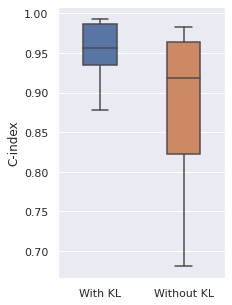

In [ ]:
import seaborn as sns

concordance_td_array = np.array(concordance_td_list)
concordance_td_array_old = np.array(concordance_td_list_old)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old)
integrated_brier_score_array = np.array(integrated_brier_score_list)
integrated_nbll_array = np.array(integrated_nbll_list)
integrated_nbll_array_old = np.array(integrated_nbll_list_old)
likelihood_array = np.array(likelihood_list)
likelihood_array_old = np.array(likelihood_list_old)

data = np.array(concordance_td_list + concordance_td_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t C-index": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t C-index', y='C-index', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")

[Text(0.5, 0, '')]

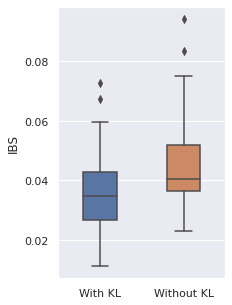

In [ ]:
data = np.array(integrated_brier_score_list + integrated_brier_score_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"IBS": data, "Comparison w.r.t IBS": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t IBS', y='IBS', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")

[Text(0.5, 0, '')]

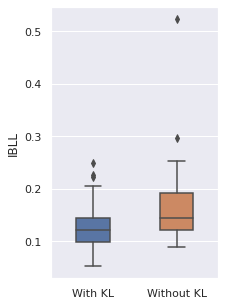

In [ ]:
data = np.array(integrated_nbll_list + integrated_nbll_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"IBLL": data, "Comparison w.r.t IBLL": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t IBLL', y='IBLL', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")

# Other Simulation Settings

We have demonstrated the usage of our model with scheme 1, which means local and prior information share the same set of covariates and local model is the true model (which is also one assumption for other schemes). We will show the results for the other 3 schemes below.

## With Much Smaller Covariates

In [ ]:
data_prior = pd.read_csv("/content/drive/My Drive/Kevin He/prior_data_subset.csv")

In [ ]:
# data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_2.csv")
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_together.csv")

In this setting, only `[Z1, Z2, Z6, Z7]` are observable, so we believe that prior information is not so good and our model should not borrow too much from it.

In [ ]:
data_prior

,Unnamed: 0,status,Z1,Z2,Z6,Z7,time
0,1,0,-0.286215,0.139929,0,1,10
1,2,0,-1.020084,0.497558,1,1,10
2,3,0,-0.657176,-0.788317,1,0,2
3,4,0,1.062820,1.694089,0,0,10
4,5,0,1.519426,1.334383,1,0,8
...,...,...,...,...,...,...,...
9995,9996,0,0.076944,0.584749,1,0,3
9996,9997,0,-0.197012,-1.493841,1,0,5
9997,9998,0,0.191691,-0.470902,1,0,9
9998,9999,0,0.950740,0.634772,1,1,2


In [ ]:
data_prior = data_prior.drop(['Unnamed: 0'], axis = 1)

In [ ]:
data_prior_expanded = dataLong(data_prior)

In [ ]:
columns = ["Z1", "Z2", "Z6", "Z7"] + ['time' + str(i + 1) for i in range(10)]
# X = np.array(data_prior[columns])
# y = np.array(data_prior['y'])
X = data_prior_expanded[columns]
y = data_prior_expanded["y"]

Note that in this setting, the algorithm will not converge to the right coefficients since the continuous covariates are not i.i.d.

In [ ]:
import statsmodels.api as sm

# train_x['intercept'] = 1.0
logit = sm.Logit(y, X)
result = logit.fit(maxiter = 10000)
result.summary()

Optimization terminated successfully.
         Current function value: 0.079739
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                59916
Model:                          Logit   Df Residuals:                    59902
Method:                           MLE   Df Model:                           13
Date:                Thu, 02 Jun 2022   Pseudo R-squ.:                  0.1242
Time:                        21:08:12   Log-Likelihood:                -4777.6
converged:                       True   LL-Null:                       -5455.4
Covariance Type:            nonrobust   LLR p-value:                6.048e-282
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Z1            -0.6939      0.037    -18.605      0.000      -0.767      -0.621
Z2            -0.2153      0.037     -5.897      0.000      -0.287      -0.144
Z6            -1.4374      0.074    -19.441      0.000      -1.582      -1.292
Z7             0.4111      0.063      6.531      0.000       0.288       0.534
time1         -3.4174      0.074    -46.240      0.000      -3.562      -3.273
time2         -4.2705      0.100    -42.699      0.000      -4.466      -4.074
time3         -4.7573      0.128    -37.059      0.000      -5.009      -4.506
time4         -3.7999      0.093    -40.713      0.000      -3.983      -3.617
time5         -4.2432      0.119    -35.697      0.000      -4.476      -4.010
time6         -4.4199      0.139    -31.733      0.000      -4.693      -4.147
time7         -3.5523      0.108    -32.897      0.000      -3.764      -3.341
time8         -3.8940      0.139    -27.953      0.000      -4.167      -3.621
time9         -3.2567      0.124    -26.214      0.000      -3.500      -3.013
time10        -4.3625      0.250    -17.443      0.000      -4.853      -3.872
==============================================================================
"""

In [ ]:
time_column = ["time" + str(i + 1) for i in range(10)]
cova_column = ["Z1", "Z2", "Z6", "Z7"]

beta_time = np.array(result.params[time_column])
beta_cova = np.array(result.params[cova_column])

In [ ]:
Z = np.array(data_local[cova_column])
Z.shape

(30000, 4)

In [ ]:
prior_info = np.dot(Z, beta_cova).reshape(-1, 1) + beta_time.reshape(1, -1)
prior_info = np.exp(prior_info) / (1 + np.exp(prior_info))

In [ ]:
time = data_local["time"]
time = np.array(time).reshape(time.shape[0], -1)
zeros = np.zeros((time.shape[0], 11))
np.put_along_axis(zeros, time, np.array(data_local["status"]).reshape(-1, 1), axis=1)
zeros = zeros[:, 1:]
zeros

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
temp = [i // 300 for i in range(30000)]
data_local['temp'] = temp 
data_local_list = data_local.groupby("temp")
data_local_list = list(data_local_list)

In [ ]:
from sklearn.model_selection import KFold # import KFold

In [ ]:
data_local_list = list(data_local_list)

concordance_td_list = []
integrated_brier_score_list = []
integrated_nbll_list = []
likelihood_list = []
concordance_td_list_old = []
integrated_brier_score_list_old = []
integrated_nbll_list_old = []
likelihood_list_old = []
best_eta_list = []
eta = 0

for i in range(20):
  print(i)
  print("Begin with CV")
  data_local = data_local_list[i][1]
  data_local = data_local.reset_index(drop = True)

  Z = np.array(data_local[cova_column])

  prior_info = np.dot(Z, beta_cova).reshape(-1, 1) + beta_time.reshape(1, -1)
  prior_info = np.exp(prior_info) / (1 + np.exp(prior_info))

  time = data_local["time"]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 11))
  np.put_along_axis(zeros, time, np.array(data_local["status"]).reshape(-1, 1), axis=1)
  zeros = zeros[:, 1:]

  combined_info = (zeros + eta * prior_info) / (1 + eta)

  data_local['time'] = data_local['time'] - 1
  
  cols_standardize = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
  cols_leave = ['Z6', 'Z7', 'Z8', 'Z9', 'Z10']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]

  data_local_mapper = DataFrameMapper(standardize + leave)

  data_local_test = data_local.sample(frac=0.2)
  data_local_train_origin = data_local.drop(data_local_test.index)

  data_local_index = np.array(data_local_train_origin.index)
  # print(data_local_index)
  # data_local_val_index = np.array(data_local_val.index)
  combined_info_train_origin = combined_info[data_local_index]

  x_train = data_local_mapper.fit_transform(data_local_train_origin).astype('float32')
  # x_val = data_local_mapper.transform(data_local_val).astype('float32')
  x_test = data_local_mapper.transform(data_local_test).astype('float32')
  X_train = x_train.copy()

  kf = KFold(n_splits=5) # Define the split - into 2 folds 
  kf.get_n_splits(X_train) # returns the number of splitting iterations in the cross-validator

  eta_list = [i for i in range(11)]

  best_eta = 0
  best_concordance = 0
  best_ibll = 10000000
  best_ibs = 10000000

  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping(patience = 5)]
  labtrans = LogisticHazard.label_transform(num_durations)

  for eta in eta_list:
    concordance_td_list_CV = []
    integrated_brier_score_list_CV = []
    integrated_nbll_list_CV = []
    likelihood_list_CV = []

    combined_info = (zeros + eta * prior_info) / (1 + eta)

    data_local_index = np.array(data_local_train_origin.index)
    combined_info_train_origin = combined_info[data_local_index]

    for train_index, test_index in kf.split(X_train):
      data_local_train_index = train_index
      data_local_val_index = test_index
      data_local_train = data_local_train_origin.iloc[data_local_train_index,]
      data_local_val = data_local_train_origin.iloc[data_local_val_index,]
      x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
      x_val = data_local_mapper.transform(data_local_val).astype('float32')
      n_train = data_local_train.shape[0]
      n_val = data_local_val.shape[0]
      y_train = (combined_info_train_origin[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
      y_val = (combined_info_train_origin[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)

      train = (x_train, y_train)
      val = (x_val, y_val)

      get_target = lambda df: (df['time'].values, df['status'].values)

      batch_size = 20
      epochs = 100
      callbacks = [tt.cb.EarlyStopping(patience = 5)]

      durations_test, events_test = get_target(data_local_val)

      num_durations = 10
      in_features = x_train.shape[1]
      num_nodes = [32, 32]
      out_features = num_durations
      batch_norm = True
      dropout = 0.1

      net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

      model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

      log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = False)

      time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
      surv = model.predict_surv_df(x_val)
      ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
      integrated_brier_score_list_CV.append(ev.integrated_brier_score(time_grid))
      integrated_nbll_list_CV.append(ev.integrated_nbll(time_grid))
      likelihood_list_CV.append(log.to_pandas().val_loss.min())
    
    integrated_brier_score = sum(integrated_brier_score_list_CV) / len(integrated_brier_score_list_CV)
    integrated_nbll = sum(integrated_nbll_list_CV) / len(integrated_nbll_list_CV)
    if(best_ibs > integrated_brier_score):
      best_ibs = integrated_brier_score
      best_eta = eta
  
  print("CV ends")
  best_eta_list.append(best_eta)
  eta = best_eta
  combined_info = (zeros + eta * prior_info) / (1 + eta)

  data_local_index = np.array(data_local_train_origin.index)
  combined_info_train = combined_info[data_local_index]
  data_local_train_origin = data_local_train_origin.reset_index(drop = True)

  # data_local_test = data_local.sample(frac=0.2)
  # data_local_train = data_local.drop(data_local_test.index)
  data_local_val = data_local_train_origin.sample(frac=0.2)
  data_local_train = data_local_train_origin.drop(data_local_val.index)

  data_local_train_index = np.array(data_local_train.index)
  data_local_val_index = np.array(data_local_val.index)

  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping(patience = 5)]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  n_train = data_local_train.shape[0]
  n_val = data_local_val.shape[0]
  y_train = (combined_info_train[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
  y_val = (combined_info_train[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)
  x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
  x_val = data_local_mapper.transform(data_local_val).astype('float32')
  x_test = data_local_mapper.transform(data_local_test).astype('float32')
  train = (x_train, y_train)
  val = (x_val, y_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = False)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  try:
    concordance_td_list.append(ev.concordance_td('antolini'))
  except:
    continue
  integrated_brier_score_list.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list.append(ev.integrated_nbll(time_grid))
  likelihood_list.append(log.to_pandas().val_loss.min())


  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping(patience = 5)]
  labtrans = LogisticHazard.label_transform(num_durations)

  y_train = labtrans.fit_transform(*get_target(data_local_train))
  y_val = labtrans.transform(*get_target(data_local_val))
  train = (x_train, y_train)
  val = (x_val, y_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = False)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  try:
    concordance_td_list_old.append(ev.concordance_td('antolini'))
  except:
    continue
  integrated_brier_score_list_old.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_old.append(ev.integrated_nbll(time_grid))
  likelihood_list_old.append(log.to_pandas().val_loss.min())

0
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
1
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
2
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
3
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
4
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
5
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
6
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
7
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
CV ends
1
11
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
12
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
13
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
14
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
15
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
16
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
17
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
18
Begin with CV
1
1
1
1
1


In this setting, we can find that our model will barely borrow the information from prior.

In [ ]:
best_eta_list

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0]

In [ ]:
import statistics as stat

print("mean: ", stat.mean(best_eta_list))
print("std var: ", stat.stdev(best_eta_list))

mean:  0.15
std var:  0.48936048492959294


For this model, it is easy to see that our model actually is comparable with LogisticHazard.

[Text(0.5, 0, '')]

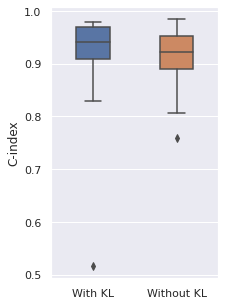

In [ ]:
import seaborn as sns

concordance_td_array = np.array(concordance_td_list)
concordance_td_array_old = np.array(concordance_td_list_old)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old)
integrated_brier_score_array = np.array(integrated_brier_score_list)
integrated_nbll_array = np.array(integrated_nbll_list)
integrated_nbll_array_old = np.array(integrated_nbll_list_old)
likelihood_array = np.array(likelihood_list)
likelihood_array_old = np.array(likelihood_list_old)

data = np.array(concordance_td_list + concordance_td_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t C-index": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t C-index', y='C-index', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")

[Text(0.5, 0, '')]

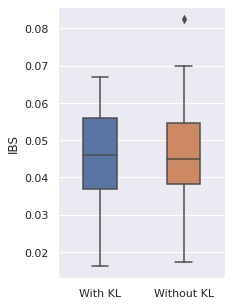

In [ ]:
data = np.array(integrated_brier_score_list + integrated_brier_score_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"IBS": data, "Comparison w.r.t IBS": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t IBS', y='IBS', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")

[Text(0.5, 0, '')]

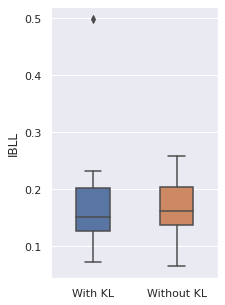

In [ ]:
data = np.array(integrated_nbll_list + integrated_nbll_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"IBLL": data, "Comparison w.r.t IBLL": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t IBLL', y='IBLL', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")

## With a little smaller covariates

In [ ]:
data_prior = pd.read_csv("/content/drive/My Drive/Kevin He/prior_data_subset_2.csv")

In [ ]:
# data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_2.csv")
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_together.csv")

In this setting, `[Z5, Z10]` are excluded, so most of the true covariates are preserved. We believe that our model should borrow some information from prior and also we can get a better result compared with other models.

In [ ]:
data_prior

,Unnamed: 0,status,Z1,Z2,Z3,Z4,Z6,Z7,Z8,Z9,time
0,1,0,-0.286215,0.139929,-0.986627,0.320499,0,1,1,1,10
1,2,0,-1.020084,0.497558,0.142357,-0.993178,1,1,1,0,10
2,3,0,-0.657176,-0.788317,-0.223124,-0.086939,1,0,1,0,2
3,4,0,1.062820,1.694089,2.028497,1.665537,0,0,0,1,10
4,5,0,1.519426,1.334383,-0.324365,-0.353265,1,0,1,1,8
...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,0,0.076944,0.584749,2.131765,1.081040,1,0,0,1,3
9996,9997,0,-0.197012,-1.493841,-1.189917,-0.810097,1,0,0,0,5
9997,9998,0,0.191691,-0.470902,-0.030415,0.251914,1,0,1,1,9
9998,9999,0,0.950740,0.634772,-0.740211,-0.000132,1,1,0,1,2


In [ ]:
data_prior = data_prior.drop(['Unnamed: 0'], axis = 1)

In [ ]:
data_prior_expanded = dataLong(data_prior)

In [ ]:
columns = ["Z1", "Z2", "Z3", "Z4", "Z6", "Z7", "Z8", "Z9"] + ['time' + str(i + 1) for i in range(10)]
# X = np.array(data_prior[columns])
# y = np.array(data_prior['y'])
X = data_prior_expanded[columns]
y = data_prior_expanded["y"]

In [ ]:
import statsmodels.api as sm

# train_x['intercept'] = 1.0
logit = sm.Logit(y, X)
result = logit.fit(maxiter = 10000)
result.summary()

Optimization terminated successfully.
         Current function value: 0.047001
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                59916
Model:                          Logit   Df Residuals:                    59898
Method:                           MLE   Df Model:                           17
Date:                Thu, 02 Jun 2022   Pseudo R-squ.:                  0.4838
Time:                        21:27:53   Log-Likelihood:                -2816.1
converged:                       True   LL-Null:                       -5455.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Z1            -1.5479      0.053    -29.212      0.000      -1.652      -1.444
Z2             0.7848      0.050     15.677      0.000       0.687       0.883
Z3            -1.6878      0.059    -28.795      0.000      -1.803      -1.573
Z4            -1.9389      0.059    -33.113      0.000      -2.054      -1.824
Z6            -3.3639      0.108    -31.224      0.000      -3.575      -3.153
Z7             0.8745      0.076     11.573      0.000       0.726       1.023
Z8            -2.4079      0.092    -26.136      0.000      -2.588      -2.227
Z9            -3.3363      0.108    -30.887      0.000      -3.548      -3.125
time1         -4.5957      0.128    -35.930      0.000      -4.846      -4.345
time2         -4.7979      0.137    -35.066      0.000      -5.066      -4.530
time3         -5.0184      0.157    -32.007      0.000      -5.326      -4.711
time4         -3.6387      0.121    -30.139      0.000      -3.875      -3.402
time5         -3.8012      0.142    -26.843      0.000      -4.079      -3.524
time6         -3.7738      0.158    -23.829      0.000      -4.084      -3.463
time7         -2.5402      0.128    -19.841      0.000      -2.791      -2.289
time8         -2.6804      0.159    -16.888      0.000      -2.991      -2.369
time9         -1.7058      0.145    -11.757      0.000      -1.990      -1.421
time10        -2.6346      0.266     -9.909      0.000      -3.156      -2.113
==============================================================================

Possibly complete quasi-separation: A fraction 0.43 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [ ]:
time_column = ["time" + str(i + 1) for i in range(10)]
cova_column = ["Z1", "Z2", "Z3", "Z4", "Z6", "Z7", "Z8", "Z9"]

beta_time = np.array(result.params[time_column])
beta_cova = np.array(result.params[cova_column])

In [ ]:
Z = np.array(data_local[cova_column])
Z.shape

(30000, 8)

In [ ]:
prior_info = np.dot(Z, beta_cova).reshape(-1, 1) + beta_time.reshape(1, -1)
prior_info = np.exp(prior_info) / (1 + np.exp(prior_info))

In [ ]:
time = data_local["time"]
time = np.array(time).reshape(time.shape[0], -1)
zeros = np.zeros((time.shape[0], 11))
np.put_along_axis(zeros, time, np.array(data_local["status"]).reshape(-1, 1), axis=1)
zeros = zeros[:, 1:]
zeros

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
temp = [i // 300 for i in range(30000)]
data_local['temp'] = temp 
data_local_list = data_local.groupby("temp")
data_local_list = list(data_local_list)

In [ ]:
from sklearn.model_selection import KFold # import KFold

In [ ]:
data_local_list = list(data_local_list)

concordance_td_list = []
integrated_brier_score_list = []
integrated_nbll_list = []
likelihood_list = []
concordance_td_list_old = []
integrated_brier_score_list_old = []
integrated_nbll_list_old = []
likelihood_list_old = []
best_eta_list = []
eta = 0

for i in range(20):
  print(i)
  print("Begin with CV")
  data_local = data_local_list[i][1]
  data_local = data_local.reset_index(drop = True)

  Z = np.array(data_local[cova_column])

  prior_info = np.dot(Z, beta_cova).reshape(-1, 1) + beta_time.reshape(1, -1)
  prior_info = np.exp(prior_info) / (1 + np.exp(prior_info))

  time = data_local["time"]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 11))
  np.put_along_axis(zeros, time, np.array(data_local["status"]).reshape(-1, 1), axis=1)
  zeros = zeros[:, 1:]

  combined_info = (zeros + eta * prior_info) / (1 + eta)

  data_local['time'] = data_local['time'] - 1
  
  cols_standardize = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
  cols_leave = ['Z6', 'Z7', 'Z8', 'Z9', 'Z10']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]

  data_local_mapper = DataFrameMapper(standardize + leave)

  data_local_test = data_local.sample(frac=0.2)
  data_local_train_origin = data_local.drop(data_local_test.index)

  data_local_index = np.array(data_local_train_origin.index)
  # print(data_local_index)
  # data_local_val_index = np.array(data_local_val.index)
  combined_info_train_origin = combined_info[data_local_index]

  x_train = data_local_mapper.fit_transform(data_local_train_origin).astype('float32')
  # x_val = data_local_mapper.transform(data_local_val).astype('float32')
  x_test = data_local_mapper.transform(data_local_test).astype('float32')
  X_train = x_train.copy()

  kf = KFold(n_splits=5) # Define the split - into 2 folds 
  kf.get_n_splits(X_train) # returns the number of splitting iterations in the cross-validator

  eta_list = [i for i in range(11)]

  best_eta = 0
  best_concordance = 0
  best_ibll = 10000000
  best_ibs = 10000000

  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping(patience = 5)]
  labtrans = LogisticHazard.label_transform(num_durations)

  for eta in eta_list:
    concordance_td_list_CV = []
    integrated_brier_score_list_CV = []
    integrated_nbll_list_CV = []
    likelihood_list_CV = []

    combined_info = (zeros + eta * prior_info) / (1 + eta)

    data_local_index = np.array(data_local_train_origin.index)
    combined_info_train_origin = combined_info[data_local_index]

    for train_index, test_index in kf.split(X_train):
      data_local_train_index = train_index
      data_local_val_index = test_index
      data_local_train = data_local_train_origin.iloc[data_local_train_index,]
      data_local_val = data_local_train_origin.iloc[data_local_val_index,]
      x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
      x_val = data_local_mapper.transform(data_local_val).astype('float32')
      n_train = data_local_train.shape[0]
      n_val = data_local_val.shape[0]
      y_train = (combined_info_train_origin[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
      y_val = (combined_info_train_origin[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)

      train = (x_train, y_train)
      val = (x_val, y_val)

      get_target = lambda df: (df['time'].values, df['status'].values)

      batch_size = 20
      epochs = 100
      callbacks = [tt.cb.EarlyStopping(patience = 5)]

      durations_test, events_test = get_target(data_local_val)

      num_durations = 10
      in_features = x_train.shape[1]
      num_nodes = [32, 32]
      out_features = num_durations
      batch_norm = True
      dropout = 0.1

      net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

      model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

      log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = False)

      time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
      surv = model.predict_surv_df(x_val)
      ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
      integrated_brier_score_list_CV.append(ev.integrated_brier_score(time_grid))
      integrated_nbll_list_CV.append(ev.integrated_nbll(time_grid))
      likelihood_list_CV.append(log.to_pandas().val_loss.min())
    
    integrated_brier_score = sum(integrated_brier_score_list_CV) / len(integrated_brier_score_list_CV)
    integrated_nbll = sum(integrated_nbll_list_CV) / len(integrated_nbll_list_CV)
    if(best_ibs > integrated_brier_score):
      best_ibs = integrated_brier_score
      best_eta = eta
  
  print("CV ends")
  best_eta_list.append(best_eta)
  eta = best_eta
  combined_info = (zeros + eta * prior_info) / (1 + eta)

  data_local_index = np.array(data_local_train_origin.index)
  combined_info_train = combined_info[data_local_index]
  data_local_train_origin = data_local_train_origin.reset_index(drop = True)

  # data_local_test = data_local.sample(frac=0.2)
  # data_local_train = data_local.drop(data_local_test.index)
  data_local_val = data_local_train_origin.sample(frac=0.2)
  data_local_train = data_local_train_origin.drop(data_local_val.index)

  data_local_train_index = np.array(data_local_train.index)
  data_local_val_index = np.array(data_local_val.index)

  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping(patience = 5)]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  n_train = data_local_train.shape[0]
  n_val = data_local_val.shape[0]
  y_train = (combined_info_train[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
  y_val = (combined_info_train[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)
  x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
  x_val = data_local_mapper.transform(data_local_val).astype('float32')
  x_test = data_local_mapper.transform(data_local_test).astype('float32')
  train = (x_train, y_train)
  val = (x_val, y_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = False)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  try:
    concordance_td_list.append(ev.concordance_td('antolini'))
  except:
    continue
  integrated_brier_score_list.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list.append(ev.integrated_nbll(time_grid))
  likelihood_list.append(log.to_pandas().val_loss.min())

  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping(patience = 5)]
  labtrans = LogisticHazard.label_transform(num_durations)

  y_train = labtrans.fit_transform(*get_target(data_local_train))
  y_val = labtrans.transform(*get_target(data_local_val))
  train = (x_train, y_train)
  val = (x_val, y_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = False)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  try:
    concordance_td_list_old.append(ev.concordance_td('antolini'))
  except:
    continue
  integrated_brier_score_list_old.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_old.append(ev.integrated_nbll(time_grid))
  likelihood_list_old.append(log.to_pandas().val_loss.min())

0
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
1
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
2
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
3
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
4
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
5
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
6
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
7
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In this setting, we can find that our model will borrow the information from prior.

In [ ]:
best_eta_list

[3, 2, 2, 3, 8, 1, 7, 3, 1, 2, 9, 2, 2, 9, 9, 5, 3, 8, 6, 4]

In [ ]:
import statistics as stat

print("mean: ", stat.mean(best_eta_list))
print("std var: ", stat.stdev(best_eta_list))

mean:  4.45
std var:  2.8923674513595627


For this model, it is easy to see that our model actually is better than LogisticHazard, but not so superior.

[Text(0.5, 0, '')]

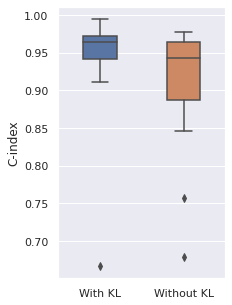

In [ ]:
import seaborn as sns

concordance_td_array = np.array(concordance_td_list)
concordance_td_array_old = np.array(concordance_td_list_old)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old)
integrated_brier_score_array = np.array(integrated_brier_score_list)
integrated_nbll_array = np.array(integrated_nbll_list)
integrated_nbll_array_old = np.array(integrated_nbll_list_old)
likelihood_array = np.array(likelihood_list)
likelihood_array_old = np.array(likelihood_list_old)

data = np.array(concordance_td_list + concordance_td_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t C-index": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t C-index', y='C-index', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")

[Text(0.5, 0, '')]

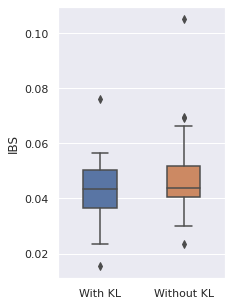

In [ ]:
data = np.array(integrated_brier_score_list + integrated_brier_score_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"IBS": data, "Comparison w.r.t IBS": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t IBS', y='IBS', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")

[Text(0.5, 0, '')]

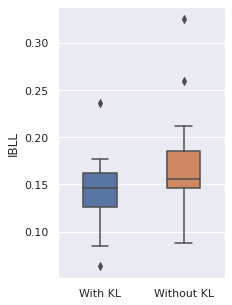

In [ ]:
data = np.array(integrated_nbll_list + integrated_nbll_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"IBLL": data, "Comparison w.r.t IBLL": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t IBLL', y='IBLL', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")

## With a little smaller covariates and noise

In [ ]:
data_prior = pd.read_csv("/content/drive/My Drive/Kevin He/prior_data_subset_4.csv")

In [ ]:
# data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_2.csv")
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_together.csv")

In this setting, 10 covariates are used but actually they are corrupted, with the 4 noises (`[Z11, Z12, Z13, Z14]`) values $[1, -2, 2, -1]$.

In [ ]:
data_prior

,Unnamed: 0,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time
0,1,0,-1.259106,-1.069068,0.426597,1.177869,-0.487250,1,0,1,1,0,10
1,2,0,0.040708,0.632739,-0.814715,-0.016209,1.219754,1,0,0,1,1,2
2,3,0,0.447862,-0.245717,0.262598,0.063008,1.643180,1,0,0,1,1,6
3,4,0,-0.236793,-0.173642,0.275600,-0.430410,-1.509375,0,0,1,1,1,3
4,5,0,0.933412,-0.463739,-1.454970,-0.840938,-1.393674,1,1,0,1,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,0,0.430031,0.547352,0.935747,-0.659854,-0.954866,1,0,0,1,1,7
9996,9997,0,-0.289461,0.790817,1.857168,1.029150,0.229936,1,0,0,0,0,2
9997,9998,0,-0.616812,-1.105220,-0.667197,-0.228677,-0.933897,0,0,1,0,1,6
9998,9999,0,-0.746467,0.089680,1.005637,0.068443,-0.411710,0,1,0,0,0,4


In [ ]:
data_prior = data_prior.drop(['Unnamed: 0'], axis = 1)

In [ ]:
data_prior_expanded = dataLong(data_prior)

In [ ]:
data_prior_expanded

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,...,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
0,0.0,-1.259106,-1.069068,0.426597,1.177869,-0.487250,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-1.259106,-1.069068,0.426597,1.177869,-0.487250,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-1.259106,-1.069068,0.426597,1.177869,-0.487250,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-1.259106,-1.069068,0.426597,1.177869,-0.487250,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-1.259106,-1.069068,0.426597,1.177869,-0.487250,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59133,0.0,-0.746467,0.089680,1.005637,0.068443,-0.411710,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59134,0.0,-0.746467,0.089680,1.005637,0.068443,-0.411710,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59135,0.0,-0.746467,0.089680,1.005637,0.068443,-0.411710,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59136,0.0,-0.746467,0.089680,1.005637,0.068443,-0.411710,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
columns = ["Z1", "Z2", "Z3", "Z4", "Z5", "Z6", "Z7", "Z8", "Z9", "Z10"] + ['time' + str(i + 1) for i in range(10)]
# X = np.array(data_prior[columns])
# y = np.array(data_prior['y'])
X = data_prior_expanded[columns]
y = data_prior_expanded["y"]

In [ ]:
import statsmodels.api as sm

# train_x['intercept'] = 1.0
logit = sm.Logit(y, X)
result = logit.fit(maxiter = 10000)
result.summary()

Optimization terminated successfully.
         Current function value: 0.055886
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                59138
Model:                          Logit   Df Residuals:                    59118
Method:                           MLE   Df Model:                           19
Date:                Thu, 02 Jun 2022   Pseudo R-squ.:                  0.4203
Time:                        23:24:59   Log-Likelihood:                -3305.0
converged:                       True   LL-Null:                       -5701.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Z1            -1.2039      0.045    -26.781      0.000      -1.292      -1.116
Z2             0.5922      0.045     13.117      0.000       0.504       0.681
Z3            -1.1085      0.048    -23.097      0.000      -1.203      -1.014
Z4            -1.8740      0.056    -33.268      0.000      -1.984      -1.764
Z5             0.7045      0.041     17.390      0.000       0.625       0.784
Z6            -2.4019      0.087    -27.531      0.000      -2.573      -2.231
Z7             0.6481      0.070      9.267      0.000       0.511       0.785
Z8            -1.7783      0.080    -22.320      0.000      -1.934      -1.622
Z9            -2.2977      0.086    -26.754      0.000      -2.466      -2.129
Z10            0.6202      0.071      8.787      0.000       0.482       0.759
time1         -3.8263      0.109    -35.036      0.000      -4.040      -3.612
time2         -4.6503      0.132    -35.169      0.000      -4.909      -4.391
time3         -4.7145      0.145    -32.570      0.000      -4.998      -4.431
time4         -3.7956      0.123    -30.875      0.000      -4.037      -3.555
time5         -3.9445      0.141    -27.978      0.000      -4.221      -3.668
time6         -4.1944      0.168    -25.016      0.000      -4.523      -3.866
time7         -2.9944      0.134    -22.429      0.000      -3.256      -2.733
time8         -3.3794      0.173    -19.516      0.000      -3.719      -3.040
time9         -2.3042      0.150    -15.338      0.000      -2.599      -2.010
time10        -2.6516      0.218    -12.154      0.000      -3.079      -2.224
==============================================================================

Possibly complete quasi-separation: A fraction 0.23 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [ ]:
# Note that the information from Z6 and Z12 will not be used

time_column = ["time" + str(i + 1) for i in range(10)]
cova_column = ["Z1", "Z2", "Z3", "Z4", "Z5", "Z6", "Z7", "Z8", "Z9", "Z10"]

beta_time = np.array(result.params[time_column])
beta_cova = np.array(result.params[cova_column])

In [ ]:
Z = np.array(data_local[cova_column])
Z.shape

(30000, 10)

In [ ]:
prior_info = np.dot(Z, beta_cova).reshape(-1, 1) + beta_time.reshape(1, -1)
prior_info = np.exp(prior_info) / (1 + np.exp(prior_info))

In [ ]:
time = data_local["time"]
time = np.array(time).reshape(time.shape[0], -1)
zeros = np.zeros((time.shape[0], 11))
np.put_along_axis(zeros, time, np.array(data_local["status"]).reshape(-1, 1), axis=1)
zeros = zeros[:, 1:]
zeros

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
temp = [i // 300 for i in range(30000)]
data_local['temp'] = temp 
data_local_list = data_local.groupby("temp")
data_local_list = list(data_local_list)

In [ ]:
from sklearn.model_selection import KFold # import KFold

In [ ]:
data_local_list = list(data_local_list)

concordance_td_list = []
integrated_brier_score_list = []
integrated_nbll_list = []
likelihood_list = []
concordance_td_list_old = []
integrated_brier_score_list_old = []
integrated_nbll_list_old = []
likelihood_list_old = []
best_eta_list = []
eta = 0

for i in range(20):
  print(i)
  print("Begin with CV")
  data_local = data_local_list[i][1]
  data_local = data_local.reset_index(drop = True)

  Z = np.array(data_local[cova_column])

  prior_info = np.dot(Z, beta_cova).reshape(-1, 1) + beta_time.reshape(1, -1)
  prior_info = np.exp(prior_info) / (1 + np.exp(prior_info))

  time = data_local["time"]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 11))
  np.put_along_axis(zeros, time, np.array(data_local["status"]).reshape(-1, 1), axis=1)
  zeros = zeros[:, 1:]

  combined_info = (zeros + eta * prior_info) / (1 + eta)

  data_local['time'] = data_local['time'] - 1
  
  cols_standardize = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
  cols_leave = ['Z6', 'Z7', 'Z8', 'Z9', 'Z10']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]

  data_local_mapper = DataFrameMapper(standardize + leave)

  data_local_test = data_local.sample(frac=0.2)
  data_local_train_origin = data_local.drop(data_local_test.index)

  data_local_index = np.array(data_local_train_origin.index)
  # print(data_local_index)
  # data_local_val_index = np.array(data_local_val.index)
  combined_info_train_origin = combined_info[data_local_index]

  x_train = data_local_mapper.fit_transform(data_local_train_origin).astype('float32')
  # x_val = data_local_mapper.transform(data_local_val).astype('float32')
  x_test = data_local_mapper.transform(data_local_test).astype('float32')
  X_train = x_train.copy()

  kf = KFold(n_splits=5) # Define the split - into 2 folds 
  kf.get_n_splits(X_train) # returns the number of splitting iterations in the cross-validator

  eta_list = [i for i in range(11)]

  best_eta = 0
  best_concordance = 0
  best_ibll = 10000000
  best_ibs = 10000000

  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping(patience = 5)]
  labtrans = LogisticHazard.label_transform(num_durations)

  for eta in eta_list:
    concordance_td_list_CV = []
    integrated_brier_score_list_CV = []
    integrated_nbll_list_CV = []
    likelihood_list_CV = []

    combined_info = (zeros + eta * prior_info) / (1 + eta)

    data_local_index = np.array(data_local_train_origin.index)
    combined_info_train_origin = combined_info[data_local_index]

    for train_index, test_index in kf.split(X_train):
      data_local_train_index = train_index
      data_local_val_index = test_index
      data_local_train = data_local_train_origin.iloc[data_local_train_index,]
      data_local_val = data_local_train_origin.iloc[data_local_val_index,]
      x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
      x_val = data_local_mapper.transform(data_local_val).astype('float32')
      n_train = data_local_train.shape[0]
      n_val = data_local_val.shape[0]
      y_train = (combined_info_train_origin[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
      y_val = (combined_info_train_origin[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)

      train = (x_train, y_train)
      val = (x_val, y_val)

      get_target = lambda df: (df['time'].values, df['status'].values)

      batch_size = 20
      epochs = 100
      callbacks = [tt.cb.EarlyStopping(patience = 5)]

      durations_test, events_test = get_target(data_local_val)

      num_durations = 10
      in_features = x_train.shape[1]
      num_nodes = [32, 32]
      out_features = num_durations
      batch_norm = True
      dropout = 0.1

      net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

      model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

      log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = False)

      time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
      surv = model.predict_surv_df(x_val)
      ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
      integrated_brier_score_list_CV.append(ev.integrated_brier_score(time_grid))
      integrated_nbll_list_CV.append(ev.integrated_nbll(time_grid))
      likelihood_list_CV.append(log.to_pandas().val_loss.min())
    
    integrated_brier_score = sum(integrated_brier_score_list_CV) / len(integrated_brier_score_list_CV)
    integrated_nbll = sum(integrated_nbll_list_CV) / len(integrated_nbll_list_CV)
    if(best_ibs > integrated_brier_score):
      best_ibs = integrated_brier_score
      best_eta = eta
  
  print("CV ends")
  best_eta_list.append(best_eta)
  eta = best_eta
  combined_info = (zeros + eta * prior_info) / (1 + eta)

  data_local_index = np.array(data_local_train_origin.index)
  combined_info_train = combined_info[data_local_index]
  data_local_train_origin = data_local_train_origin.reset_index(drop = True)

  # data_local_test = data_local.sample(frac=0.2)
  # data_local_train = data_local.drop(data_local_test.index)
  data_local_val = data_local_train_origin.sample(frac=0.2)
  data_local_train = data_local_train_origin.drop(data_local_val.index)

  data_local_train_index = np.array(data_local_train.index)
  data_local_val_index = np.array(data_local_val.index)

  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping(patience = 5)]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  n_train = data_local_train.shape[0]
  n_val = data_local_val.shape[0]
  y_train = (combined_info_train[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
  y_val = (combined_info_train[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)
  x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
  x_val = data_local_mapper.transform(data_local_val).astype('float32')
  x_test = data_local_mapper.transform(data_local_test).astype('float32')
  train = (x_train, y_train)
  val = (x_val, y_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = False)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  try:
    concordance_td_list.append(ev.concordance_td('antolini'))
  except:
    continue
  integrated_brier_score_list.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list.append(ev.integrated_nbll(time_grid))
  likelihood_list.append(log.to_pandas().val_loss.min())

  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping(patience = 5)]
  labtrans = LogisticHazard.label_transform(num_durations)

  y_train = labtrans.fit_transform(*get_target(data_local_train))
  y_val = labtrans.transform(*get_target(data_local_val))
  train = (x_train, y_train)
  val = (x_val, y_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = False)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  try:
    concordance_td_list_old.append(ev.concordance_td('antolini'))
  except:
    continue
  integrated_brier_score_list_old.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_old.append(ev.integrated_nbll(time_grid))
  likelihood_list_old.append(log.to_pandas().val_loss.min())

0
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
1
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
2
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
3
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
4
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
5
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
6
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
7
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
1
1
1


/content/drive/MyDrive/pycox/pycox/evaluation/ipcw.py:56: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(scores, axis=1) / np.sum(weights, axis=1)


1
1
CV ends
1
11
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
12
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
13
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
14
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
15
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
16
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
17
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
18
Begin with CV
1
1
1
1
1


In this setting, we can find that model does not borrow too much from the prior. So we guess that our model should be comparable.

In [ ]:
best_eta_list

[7, 1, 5, 8, 2, 2, 2, 10, 10, 10, 0, 3, 5, 9, 9, 3, 7, 6, 1, 4]

In [ ]:
import statistics as stat

print("mean: ", stat.mean(best_eta_list))
print("std var: ", stat.stdev(best_eta_list))

mean:  5.2
std var:  3.381061807682377


For this model, it is easy to see that our model actually is better than LogisticHazard, but not so superior.

[Text(0.5, 0, '')]

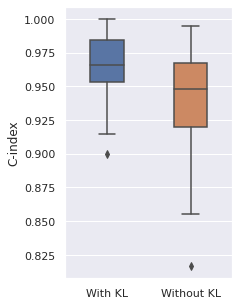

In [ ]:
import seaborn as sns

concordance_td_array = np.array(concordance_td_list)
concordance_td_array_old = np.array(concordance_td_list_old)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old)
integrated_brier_score_array = np.array(integrated_brier_score_list)
integrated_nbll_array = np.array(integrated_nbll_list)
integrated_nbll_array_old = np.array(integrated_nbll_list_old)
likelihood_array = np.array(likelihood_list)
likelihood_array_old = np.array(likelihood_list_old)

data = np.array(concordance_td_list + concordance_td_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t C-index": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t C-index', y='C-index', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")

[Text(0.5, 0, '')]

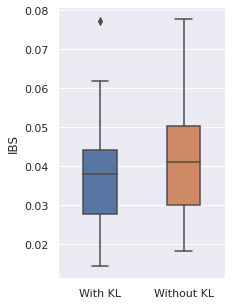

In [ ]:
data = np.array(integrated_brier_score_list + integrated_brier_score_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"IBS": data, "Comparison w.r.t IBS": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t IBS', y='IBS', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")

[Text(0.5, 0, '')]

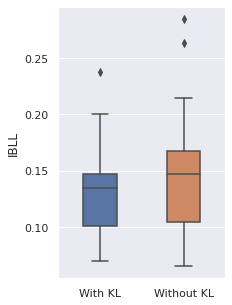

In [ ]:
data = np.array(integrated_nbll_list + integrated_nbll_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"IBLL": data, "Comparison w.r.t IBLL": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t IBLL', y='IBLL', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")

## With a little smaller covariates and noise

In [7]:
data_prior = pd.read_csv("/content/drive/My Drive/Kevin He/prior_data_subset_5.csv")

In [8]:
# data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_2.csv")
data_local = pd.read_csv("/content/drive/My Drive/Kevin He/local_data_together.csv")

In this setting, 10 covariates are used but actually they are corrupted, with the 4 noises (`[Z11, Z12, Z13, Z14]`) values $[10, -20, 20, -10]$. This means that the prior information will be affected a lot. 

In [9]:
data_prior

,Unnamed: 0,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,time
0,1,0,0.423275,0.972396,1.298318,1.677869,0.487374,1,1,1,1,1,10
1,2,1,-0.324321,0.586604,0.282597,0.991111,-0.959670,0,1,1,1,0,1
2,3,1,0.362368,-0.711247,-0.211215,-0.121474,0.519779,0,0,1,1,1,1
3,4,0,1.531660,-0.440604,-0.899696,-1.465862,0.139817,0,1,0,1,0,9
4,5,0,0.057858,0.581563,-0.499652,0.217607,0.409038,0,0,0,1,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,0,0.022891,-0.962982,-0.070234,-1.106874,0.783345,0,0,0,1,0,9
9996,9997,0,-0.208353,0.587642,1.473819,1.140233,-1.001162,1,0,1,0,0,6
9997,9998,0,0.195120,-0.362100,-0.153369,0.531035,-0.021466,0,1,0,1,0,8
9998,9999,0,-1.144044,-1.572178,-2.236485,0.371558,1.391193,1,1,0,0,0,3


In [10]:
data_prior = data_prior.drop(['Unnamed: 0'], axis = 1)

In [14]:
data_prior_expanded = dataLong(data_prior)

In [15]:
data_prior_expanded

,status,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,...,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
0,0.0,0.423275,0.972396,1.298318,1.677869,0.487374,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.423275,0.972396,1.298318,1.677869,0.487374,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.423275,0.972396,1.298318,1.677869,0.487374,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.423275,0.972396,1.298318,1.677869,0.487374,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.423275,0.972396,1.298318,1.677869,0.487374,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42965,0.0,0.195120,-0.362100,-0.153369,0.531035,-0.021466,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
42966,0.0,-1.144044,-1.572178,-2.236485,0.371558,1.391193,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42967,0.0,-1.144044,-1.572178,-2.236485,0.371558,1.391193,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42968,0.0,-1.144044,-1.572178,-2.236485,0.371558,1.391193,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
columns = ["Z1", "Z2", "Z3", "Z4", "Z5", "Z6", "Z7", "Z8", "Z9", "Z10"] + ['time' + str(i + 1) for i in range(10)]
# X = np.array(data_prior[columns])
# y = np.array(data_prior['y'])
X = data_prior_expanded[columns]
y = data_prior_expanded["y"]

In [17]:
import statsmodels.api as sm

# train_x['intercept'] = 1.0
logit = sm.Logit(y, X)
result = logit.fit(maxiter = 10000)
result.summary()

Optimization terminated successfully.
         Current function value: 0.193854
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                42970
Model:                          Logit   Df Residuals:                    42950
Method:                           MLE   Df Model:                           19
Date:                Tue, 07 Jun 2022   Pseudo R-squ.:                  0.3772
Time:                        03:08:21   Log-Likelihood:                -8329.9
converged:                       True   LL-Null:                       -13375.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Z1            -0.1325      0.023     -5.820      0.000      -0.177      -0.088
Z2             0.0428      0.026      1.677      0.094      -0.007       0.093
Z3            -0.1105      0.026     -4.312      0.000      -0.161      -0.060
Z4            -0.1101      0.025     -4.375      0.000      -0.159      -0.061
Z5             0.4431      0.023     19.053      0.000       0.397       0.489
Z6            -0.2991      0.039     -7.589      0.000      -0.376      -0.222
Z7            -0.0324      0.039     -0.823      0.411      -0.109       0.045
Z8            -0.1531      0.039     -3.888      0.000      -0.230      -0.076
Z9            -0.1414      0.039     -3.592      0.000      -0.219      -0.064
Z10           -0.0069      0.039     -0.175      0.861      -0.084       0.070
time1         -0.2605      0.048     -5.403      0.000      -0.355      -0.166
time2         -3.7760      0.107    -35.309      0.000      -3.986      -3.566
time3         -4.5147      0.156    -28.986      0.000      -4.820      -4.209
time4         -3.8825      0.125    -31.114      0.000      -4.127      -3.638
time5         -4.6308      0.188    -24.604      0.000      -5.000      -4.262
time6         -4.4419      0.185    -23.950      0.000      -4.805      -4.078
time7         -3.8251      0.153    -24.951      0.000      -4.126      -3.525
time8         -4.8056      0.272    -17.698      0.000      -5.338      -4.273
time9         -4.3937      0.255    -17.233      0.000      -4.893      -3.894
time10        -4.2742      0.294    -14.557      0.000      -4.850      -3.699
==============================================================================
"""

In [18]:
# Note that the information from Z6 and Z12 will not be used

time_column = ["time" + str(i + 1) for i in range(10)]
cova_column = ["Z1", "Z2", "Z3", "Z4", "Z5", "Z6", "Z7", "Z8", "Z9", "Z10"]

beta_time = np.array(result.params[time_column])
beta_cova = np.array(result.params[cova_column])

In [19]:
Z = np.array(data_local[cova_column])
Z.shape

(30000, 10)

In [20]:
prior_info = np.dot(Z, beta_cova).reshape(-1, 1) + beta_time.reshape(1, -1)
prior_info = np.exp(prior_info) / (1 + np.exp(prior_info))

In [21]:
time = data_local["time"]
time = np.array(time).reshape(time.shape[0], -1)
zeros = np.zeros((time.shape[0], 11))
np.put_along_axis(zeros, time, np.array(data_local["status"]).reshape(-1, 1), axis=1)
zeros = zeros[:, 1:]
zeros

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
temp = [i // 300 for i in range(30000)]
data_local['temp'] = temp 
data_local_list = data_local.groupby("temp")
data_local_list = list(data_local_list)

In [23]:
from sklearn.model_selection import KFold # import KFold

In [30]:
data_local_list = list(data_local_list)

concordance_td_list = []
integrated_brier_score_list = []
integrated_nbll_list = []
likelihood_list = []
concordance_td_list_old = []
integrated_brier_score_list_old = []
integrated_nbll_list_old = []
likelihood_list_old = []
best_eta_list = []
eta = 0

for i in range(20):
  print(i)
  if(i == 17):
    continue
  print("Begin with CV")
  data_local = data_local_list[i][1]
  data_local = data_local.reset_index(drop = True)

  Z = np.array(data_local[cova_column])

  prior_info = np.dot(Z, beta_cova).reshape(-1, 1) + beta_time.reshape(1, -1)
  prior_info = np.exp(prior_info) / (1 + np.exp(prior_info))

  time = data_local["time"]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 11))
  np.put_along_axis(zeros, time, np.array(data_local["status"]).reshape(-1, 1), axis=1)
  zeros = zeros[:, 1:]

  combined_info = (zeros + eta * prior_info) / (1 + eta)

  data_local['time'] = data_local['time'] - 1
  
  cols_standardize = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
  cols_leave = ['Z6', 'Z7', 'Z8', 'Z9', 'Z10']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]

  data_local_mapper = DataFrameMapper(standardize + leave)

  data_local_test = data_local.sample(frac=0.2)
  data_local_train_origin = data_local.drop(data_local_test.index)

  data_local_index = np.array(data_local_train_origin.index)
  # print(data_local_index)
  # data_local_val_index = np.array(data_local_val.index)
  combined_info_train_origin = combined_info[data_local_index]

  x_train = data_local_mapper.fit_transform(data_local_train_origin).astype('float32')
  # x_val = data_local_mapper.transform(data_local_val).astype('float32')
  x_test = data_local_mapper.transform(data_local_test).astype('float32')
  X_train = x_train.copy()

  kf = KFold(n_splits=5) # Define the split - into 2 folds 
  kf.get_n_splits(X_train) # returns the number of splitting iterations in the cross-validator

  eta_list = [i for i in range(11)]

  best_eta = 0
  best_concordance = 0
  best_ibll = 10000000
  best_ibs = 10000000

  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping(patience = 5)]
  labtrans = LogisticHazard.label_transform(num_durations)

  for eta in eta_list:
    concordance_td_list_CV = []
    integrated_brier_score_list_CV = []
    integrated_nbll_list_CV = []
    likelihood_list_CV = []

    combined_info = (zeros + eta * prior_info) / (1 + eta)

    data_local_index = np.array(data_local_train_origin.index)
    combined_info_train_origin = combined_info[data_local_index]

    for train_index, test_index in kf.split(X_train):
      data_local_train_index = train_index
      data_local_val_index = test_index
      data_local_train = data_local_train_origin.iloc[data_local_train_index,]
      data_local_val = data_local_train_origin.iloc[data_local_val_index,]
      x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
      x_val = data_local_mapper.transform(data_local_val).astype('float32')
      n_train = data_local_train.shape[0]
      n_val = data_local_val.shape[0]
      y_train = (combined_info_train_origin[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
      y_val = (combined_info_train_origin[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)

      train = (x_train, y_train)
      val = (x_val, y_val)

      get_target = lambda df: (df['time'].values, df['status'].values)

      batch_size = 20
      epochs = 100
      callbacks = [tt.cb.EarlyStopping(patience = 5)]

      durations_test, events_test = get_target(data_local_val)

      num_durations = 10
      in_features = x_train.shape[1]
      num_nodes = [32, 32]
      out_features = num_durations
      batch_norm = True
      dropout = 0.1

      net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

      model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

      log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = False)

      time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
      surv = model.predict_surv_df(x_val)
      ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
      integrated_brier_score_list_CV.append(ev.integrated_brier_score(time_grid))
      integrated_nbll_list_CV.append(ev.integrated_nbll(time_grid))
      likelihood_list_CV.append(log.to_pandas().val_loss.min())
    
    integrated_brier_score = sum(integrated_brier_score_list_CV) / len(integrated_brier_score_list_CV)
    integrated_nbll = sum(integrated_nbll_list_CV) / len(integrated_nbll_list_CV)
    if(best_ibs > integrated_brier_score):
      best_ibs = integrated_brier_score
      best_eta = eta
  
  print("CV ends")
  best_eta_list.append(best_eta)
  eta = best_eta
  combined_info = (zeros + eta * prior_info) / (1 + eta)

  data_local_index = np.array(data_local_train_origin.index)
  combined_info_train = combined_info[data_local_index]
  data_local_train_origin = data_local_train_origin.reset_index(drop = True)

  # data_local_test = data_local.sample(frac=0.2)
  # data_local_train = data_local.drop(data_local_test.index)
  data_local_val = data_local_train_origin.sample(frac=0.2)
  data_local_train = data_local_train_origin.drop(data_local_val.index)

  data_local_train_index = np.array(data_local_train.index)
  data_local_val_index = np.array(data_local_val.index)

  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping(patience = 5)]
  labtrans = LogisticHazard.label_transform(num_durations)
  # labtrans = PMF.label_transform(num_durations)
  # labtrans = DeepHitSingle.label_transform(num_durations)
  n_train = data_local_train.shape[0]
  n_val = data_local_val.shape[0]
  y_train = (combined_info_train[data_local_train_index], data_local_train['time'].values, data_local_train['status'].values)
  y_val = (combined_info_train[data_local_val_index], data_local_val['time'].values, data_local_val['status'].values)
  x_train = data_local_mapper.fit_transform(data_local_train).astype('float32')
  x_val = data_local_mapper.transform(data_local_val).astype('float32')
  x_test = data_local_mapper.transform(data_local_test).astype('float32')
  train = (x_train, y_train)
  val = (x_val, y_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  # We don't need to transform the test labels
  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = False)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  try:
    concordance_td_list.append(ev.concordance_td('antolini'))
  except:
    continue
  integrated_brier_score_list.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list.append(ev.integrated_nbll(time_grid))
  likelihood_list.append(log.to_pandas().val_loss.min())

  num_durations = 10
  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping(patience = 5)]
  labtrans = LogisticHazard.label_transform(num_durations)

  y_train = labtrans.fit_transform(*get_target(data_local_train))
  y_val = labtrans.transform(*get_target(data_local_val))
  train = (x_train, y_train)
  val = (x_val, y_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = num_durations
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  durations_test, events_test = get_target(data_local_test)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = False)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  try:
    concordance_td_list_old.append(ev.concordance_td('antolini'))
  except:
    continue
  integrated_brier_score_list_old.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_old.append(ev.integrated_nbll(time_grid))
  likelihood_list_old.append(log.to_pandas().val_loss.min())

0
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
1
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
2
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
3
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
4
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
5
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
6
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
CV ends
1
7
Begin with CV
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In this setting, we can find that model does not borrow too much from the prior. So we guess that our model should be comparable.

In [31]:
best_eta_list

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [32]:
import statistics as stat

print("mean: ", stat.mean(best_eta_list))
print("std var: ", stat.stdev(best_eta_list))

mean:  0
std var:  0.0


For this model, it is easy to see that our model actually is better than LogisticHazard, but not so superior.

[Text(0.5, 0, '')]

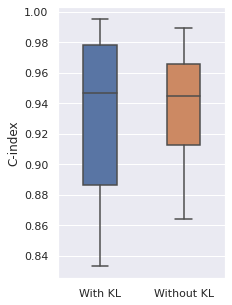

In [33]:
import seaborn as sns

concordance_td_array = np.array(concordance_td_list)
concordance_td_array_old = np.array(concordance_td_list_old)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old)
integrated_brier_score_array = np.array(integrated_brier_score_list)
integrated_nbll_array = np.array(integrated_nbll_list)
integrated_nbll_array_old = np.array(integrated_nbll_list_old)
likelihood_array = np.array(likelihood_list)
likelihood_array_old = np.array(likelihood_list_old)

data = np.array(concordance_td_list + concordance_td_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t C-index": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t C-index', y='C-index', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")

[Text(0.5, 0, '')]

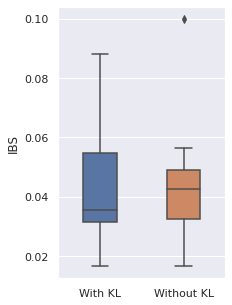

In [34]:
data = np.array(integrated_brier_score_list + integrated_brier_score_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"IBS": data, "Comparison w.r.t IBS": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t IBS', y='IBS', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")

[Text(0.5, 0, '')]

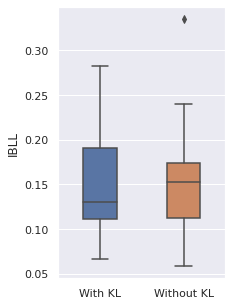

In [35]:
data = np.array(integrated_nbll_list + integrated_nbll_list_old)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"IBLL": data, "Comparison w.r.t IBLL": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t IBLL', y='IBLL', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")